In [1]:
import os
import cv2
import json
import matplotlib.pyplot as plt
from utils import load_image
from imutils.paths import list_images
from pprint import pprint

In [2]:
json_dict = {
    'flickr': './FLICKR.json',
    'splunk': './Splunk.json',
}

datasets = {
    'flickr': '/media/choppy/WD_BLACK/datasets',
    'splunk': '/media/choppy/WD_BLACK/datasets',
}

In [3]:
for json_key in json_dict.keys():
    js = json.load(open(json_dict[json_key]))
    print(f'Length of dataset {json_key}: {len(js)}\n')
    
    attacks = []
    bonafide = []
    
    for elem in js:
        # pprint(elem)
        split = elem.get('image_dir').split(os.sep)
        if split[1] == 'attack':
            attacks.append(elem)
        else:
            bonafide.append(elem)
    
    print(f'bonafide len: {len(bonafide)}')
    print(f'attack len: {len(attacks)}\n\n')
    
    # break

Length of dataset flickr: 13668

bonafide len: 3000
attack len: 10668


Length of dataset splunk: 19858

bonafide len: 2017
attack len: 17841




In [4]:
# agrupar imagenes y metadata en bonafide vs ataque y contar cuantas imagenes pasaron vs cuantas deberian ser
# generar array con indices de imagenes por cada dataset y guardarlo

In [5]:
len(bonafide), len(attacks)

(2017, 17841)

In [6]:
elem

{'image_dir': 'Splunk/bonafide/RONDA7_SPLUNK_BONAFIDE/0012/S5947.jpg',
 'mtcnn-inference': {'box': [290, 130, 670, 700],
  'confidence': 0.9243233799934387,
  'keypoints': {'left_eye': [550, 340],
   'right_eye': [850, 340],
   'nose': [720, 460],
   'mouth_left': [570, 630],
   'mouth_right': [810, 640]}},
 'handcrafted': {'periocular': [225, 455, 290, 960]}}

In [7]:
elem.get('mtcnn-inference')['box']

[290, 130, 670, 700]

/media/choppy/WD_BLACK/datasets/FLICKR/attack/ronda3/F_print_brillante_plano/F012000_print_brillante_plano_20220325194618.jpg
ye
[2230, 2073] [5980, 3377]


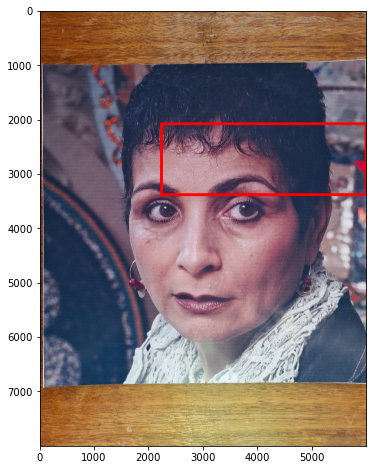

/media/choppy/WD_BLACK/datasets/FLICKR/attack/ronda3/F_print_brillante_plano/F08414_print_brillante_plano_20220323221805.jpg
ye
[1890, 2129] [5760, 3541]


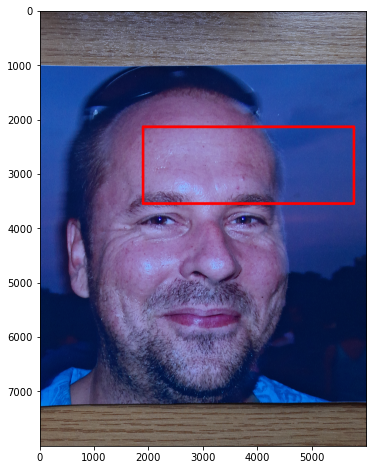

/media/choppy/WD_BLACK/datasets/FLICKR/attack/ronda3/F_print_brillante_plano/F08416_print_brillante_plano_20220323222223.jpg
ye
[2230, 2010] [5890, 3390]


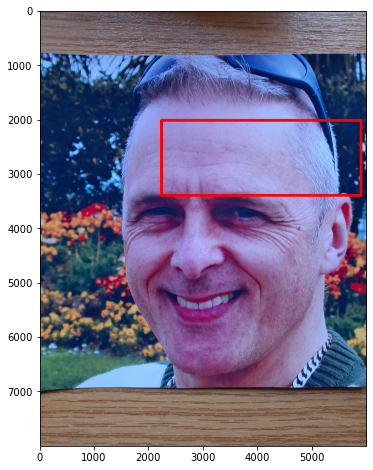

/media/choppy/WD_BLACK/datasets/FLICKR/attack/ronda3/F_print_brillante_plano/F08421_print_brillante_plano_20220323222522.jpg
ye
[1910, 2304] [5520, 3606]


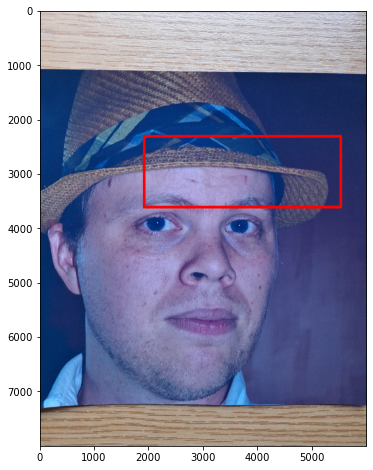

/media/choppy/WD_BLACK/datasets/FLICKR/attack/ronda3/F_print_brillante_plano/F08422_print_brillante_plano_20220323222919.jpg
ye
[1470, 2208] [5580, 3682]


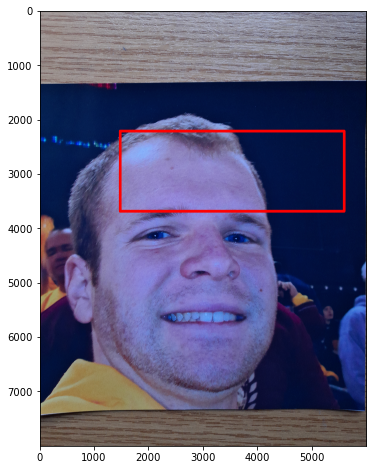

In [8]:
# calcular area, ancho y largo de zonas perioculares

i = 0

for json_key in json_dict:
    js = json.load(open(json_dict[json_key]))
    
    for elem in js:
        imdir = elem.get('image_dir')
        imdir = os.path.join(datasets[json_key], imdir)
        print(imdir)
        
        if os.path.isfile(imdir):
            print('ye')
            image = load_image(imdir)
            box_peri = elem.get('handcrafted').get('periocular')
            pt1, pt2 = [1, 2], [1, 2]
            pt1[1], pt2[1], pt1[0], pt2[0] = box_peri
            
            
            # crop = image[pt11:pt21, pt12:pt22, ...]
            # crop = image[pt21:pt11, pt12:pt22, ...] # error
            # crop = image[pt12:pt22, pt11:pt21, ...]
            
            # pt1[0], pt1[1], pt2[0], pt2[1] = y1, x1, y2, x2
            # pt1[1], pt2[1], pt1[0], pt2[0] = y1, y2, x1, x2
            periocular = cv2.rectangle(image, pt2, pt1, color=[255, 0, 0], thickness=50)
            print(pt1, pt2)
            
            
            plt.figure(figsize=(10, 8))
            # plt.imshow(image)
            plt.imshow(periocular)
            plt.show()
            i += 1
            if i == 5: break
        else:
            continue
        
    break

In [9]:
# TODO:
# 0. contar cuantas imagenes pasaron por el detector y explicar por que las otras no
# 1. agrupar imagenes en bonafide vs atk1 vs atk2 vs atk_n
# 1.1. ojala bonafide sea una carpeta con carpetas y los impostores sean tambien una carpeta con carpetas

# 2. respetar metodologia de entrenamiento
# primero caras -> recortarlas
# despues periocular